# Generative Adversarial Networks with MedNIST Dataset

This notebook illustrates the use of MONAI for training a network to generate images from a random input tensor. A simple GAN is employed to do with a separate Generator and Discriminator networks.

This will go through the steps of:
* Loading the data from a remote source
* Constructing a dataset from this data and transforms
* Defining the networks
* Training and evaluation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/MONAI/blob/master/examples/notebooks/mednist_GAN_tutorial.ipynb)

## Setup environment

In [1]:
%pip install -qU monai

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -qU matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import io
import tarfile
import urllib

import matplotlib.pyplot as plt
import torch

from monai.config import print_config
from monai.data import CacheDataset
from monai.networks import normal_init
from monai.networks.nets import Discriminator, Generator
from monai.transforms import (
    AddChannel,
    Compose,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
    Transform,
)
from monai.utils import progress_bar, set_determinism

print_config()

MONAI version: 0.2.0
Python version: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31)  [GCC 7.3.0]
Numpy version: 1.18.1
Pytorch version: 1.6.0

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.1.1
scikit-image version: 0.15.0
Pillow version: 7.0.0
Tensorboard version: 2.1.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set deterministic training for reproducibility

In [2]:
set_determinism(seed=0)

## Define training variables

In [3]:
disc_train_interval = 1
disc_train_steps = 5
batch_size = 300
latent_size = 64
num_epochs = 50
real_label = 1
gen_label = 0
learning_rate = 2e-4
betas = (0.5, 0.999)

## Download dataset

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).


If you use the MedNIST dataset, please acknowledge the source, e.g.  
https://github.com/Project-MONAI/MONAI/blob/master/examples/notebooks/mednist_tutorial.ipynb.

The method for loading the data from the remote source differs here to demonstrate how to download and read from a tar file without using the filesystem, and because we only want the images of hand X-rays. This isn't a classification example so the category data isn't needed, so we'll download the tarball, open it using the standard library, and recall all of the file names for hands:

In [4]:
resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"

remote_file = urllib.request.urlopen(resource)
dat = io.BytesIO(remote_file.read())

tar = tarfile.open("MedNIST.tar.gz", fileobj=dat)
hands = [n for n in tar.getnames() if "Hand" in n and ".jpeg" in n]

To load the actual image data from the tarfile, we define a transform type to do this using Matplotlib. This is used with other transforms for preparing the data followed by randomized augmentation transforms. The `CacheDataset` class is used here to cache all of the prepared images from the tarball, so we will have in memory all of the prepared images ready to be augmented with randomized rotation, flip, and zoom operations:

In [ ]:
class LoadTarJpeg(Transform):
    def __call__(self, data):
        return plt.imread(tar.extractfile(data))


train_transforms = Compose(
    [
        LoadTarJpeg(),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=15, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
    ]
)

train_ds = CacheDataset(hands, train_transforms)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=10
)

We now define out generator and discriminator networks. The parameters are carefully chosen to suit the image size of `(1, 64, 64)` as loaded from the tar file. Input images to the discriminator are downsampled four times to produce very small images which are flattened and passed as input to a fully-connected layer. The input latent vectors to the generator are passed through a fully-connected layer to produce an output of shape `(64, 8, 8)`, this is then upsampled three times to produce a final output which is the same shape as the real images. The networks are initialized with a normalization scheme to improve results:

In [6]:
device = torch.device("cuda:0")
disc_net = Discriminator(
    in_shape=(1, 64, 64),
    channels=(8, 16, 32, 64, 1),
    strides=(2, 2, 2, 2, 1),
    num_res_units=1,
    kernel_size=5,
).to(device)


gen_net = Generator(
    latent_shape=latent_size, start_shape=(64, 8, 8), channels=[32, 16, 8, 1], strides=[2, 2, 2, 1],
)

# initialize both networks
disc_net.apply(normal_init)
gen_net.apply(normal_init)

# input images are scaled to [0,1] so enforce the same of generated outputs
gen_net.conv.add_module("activation", torch.nn.Sigmoid())
gen_net = gen_net.to(device)

Now we define the loss functions to use with helper functions to wrap the loss calculation process for the generator and the discriminator. We also define our optimizers:

In [7]:
disc_loss = torch.nn.BCELoss()
gen_loss = torch.nn.BCELoss()

disc_opt = torch.optim.Adam(disc_net.parameters(), learning_rate, betas=betas)
gen_opt = torch.optim.Adam(gen_net.parameters(), learning_rate, betas=betas)


def discriminator_loss(gen_images, real_images):
    """
    The discriminator loss if calculated by comparing its
    prediction for real and generated images.

    """
    real = real_images.new_full((real_images.shape[0], 1), real_label)
    gen = gen_images.new_full((gen_images.shape[0], 1), gen_label)

    realloss = disc_loss(disc_net(real_images), real)
    genloss = disc_loss(disc_net(gen_images.detach()), gen)

    return (realloss + genloss) / 2


def generator_loss(input):
    """
    The generator loss is calculated by determining how well
    the discriminator was fooled by the generated images.

    """
    output = disc_net(input)
    cats = output.new_full(output.shape, real_label)
    return gen_loss(output, cats)

We now train by iterating over the dataset for a number of epochs. At certain after the generator training stage for each batch, the discriminator is trained for a number of steps on the same real and generated images.

In [8]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = [(0, 0)]
gen_step_loss = []
disc_step_loss = []
step = 0

for epoch in range(num_epochs):
    gen_net.train()
    disc_net.train()
    epoch_loss = 0

    for i, batch_data in enumerate(train_loader):
        progress_bar(
            i, len(train_loader), f"epoch {epoch + 1}, avg loss: {epoch_loss_values[-1][1]:.4f}",
        )
        real_images = batch_data.to(device)
        latent = torch.randn(real_images.shape[0], latent_size).to(device)

        gen_opt.zero_grad()
        gen_images = gen_net(latent)
        loss = generator_loss(gen_images)
        loss.backward()
        gen_opt.step()
        epoch_loss += loss.item()

        gen_step_loss.append((step, loss.item()))

        if step % disc_train_interval == 0:
            disc_total_loss = 0

            for _ in range(disc_train_steps):
                disc_opt.zero_grad()
                dloss = discriminator_loss(gen_images, real_images)
                dloss.backward()
                disc_opt.step()
                disc_total_loss += dloss.item()

            disc_step_loss.append((step, disc_total_loss / disc_train_steps))

        step += 1

    epoch_loss /= step
    epoch_loss_values.append((step, epoch_loss))

The separate loss values for the generator and discriminator can be graphed together. These should reach an equilibrium as the generator's ability to fool the discriminator balances with that networks ability to discriminate accurately between real and fake images.

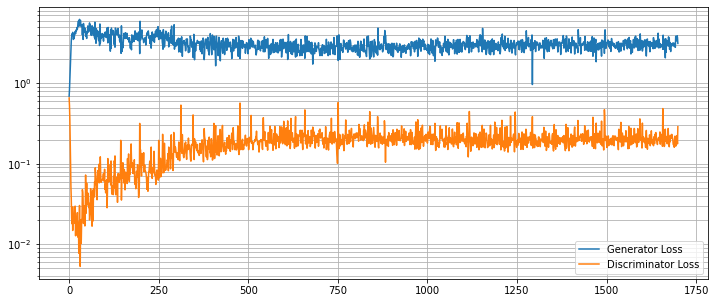

In [9]:
plt.figure(figsize=(12, 5))
plt.semilogy(*zip(*gen_step_loss), label="Generator Loss")
plt.semilogy(*zip(*disc_step_loss), label="Discriminator Loss")
plt.grid(True, "both", "both")
plt.legend()

Finally we show a few randomly generated images. Hopefully most images will have four fingers and a thumb as expected (assuming polydactyl examples were not present in large numbers in the dataset). This demonstrative notebook doesn't train the networks for long, training beyond the default 50 epochs should improve results.

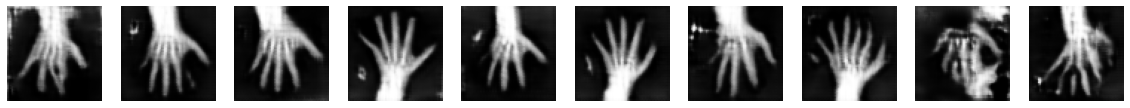

In [10]:
test_size = 10
test_latent = torch.randn(test_size, latent_size).to(device)

test_images = gen_net(test_latent)

fig, axs = plt.subplots(1, test_size, figsize=(20, 4))

for i, ax in enumerate(axs):
    ax.axis("off")
    ax.imshow(test_images[i, 0].cpu().data.numpy(), cmap="gray")